# RNAseq analysis of _D. novameixcana_ females after con- and heterospecific mating

## Introduction

The data files used in this analysis were generated within a Snakemake workflow. Breifly, RNAseq reads were generated from _D. novamexicana_ female samples (heads, ovaries, reproductive tracts, and gonadecotmized abdomen + thorax) that were either from mated females or virgin females. In addition, male _D. novamexicana_ RNAseq reads from a previous study were included in the analysis. First, reads were mapped to the virilis genome (dvir1.06) with HISAT and abundance estimates were derived. Second, the transcriptome structure produced by the genome mapping was utilized in making a canonical genome-based transcriptome that was also queried for abundance with eXpress. Finally, mapped and unmapped reads were used to generate a genome-guided transcriptome assembly and a _de novo_ transcriptome assembly, respectively, using Trinity. Transcripts from both Trinity runs were merged and abundance estimates for the samples were obtained using eXpress. 

The genome-based transcriptome and the Trinity transcriptome were both used to generate a Trinotate annotation. The workflow for these analyses is illustrated below (double-click to enlarge), and the link to the GitHub repository is here.

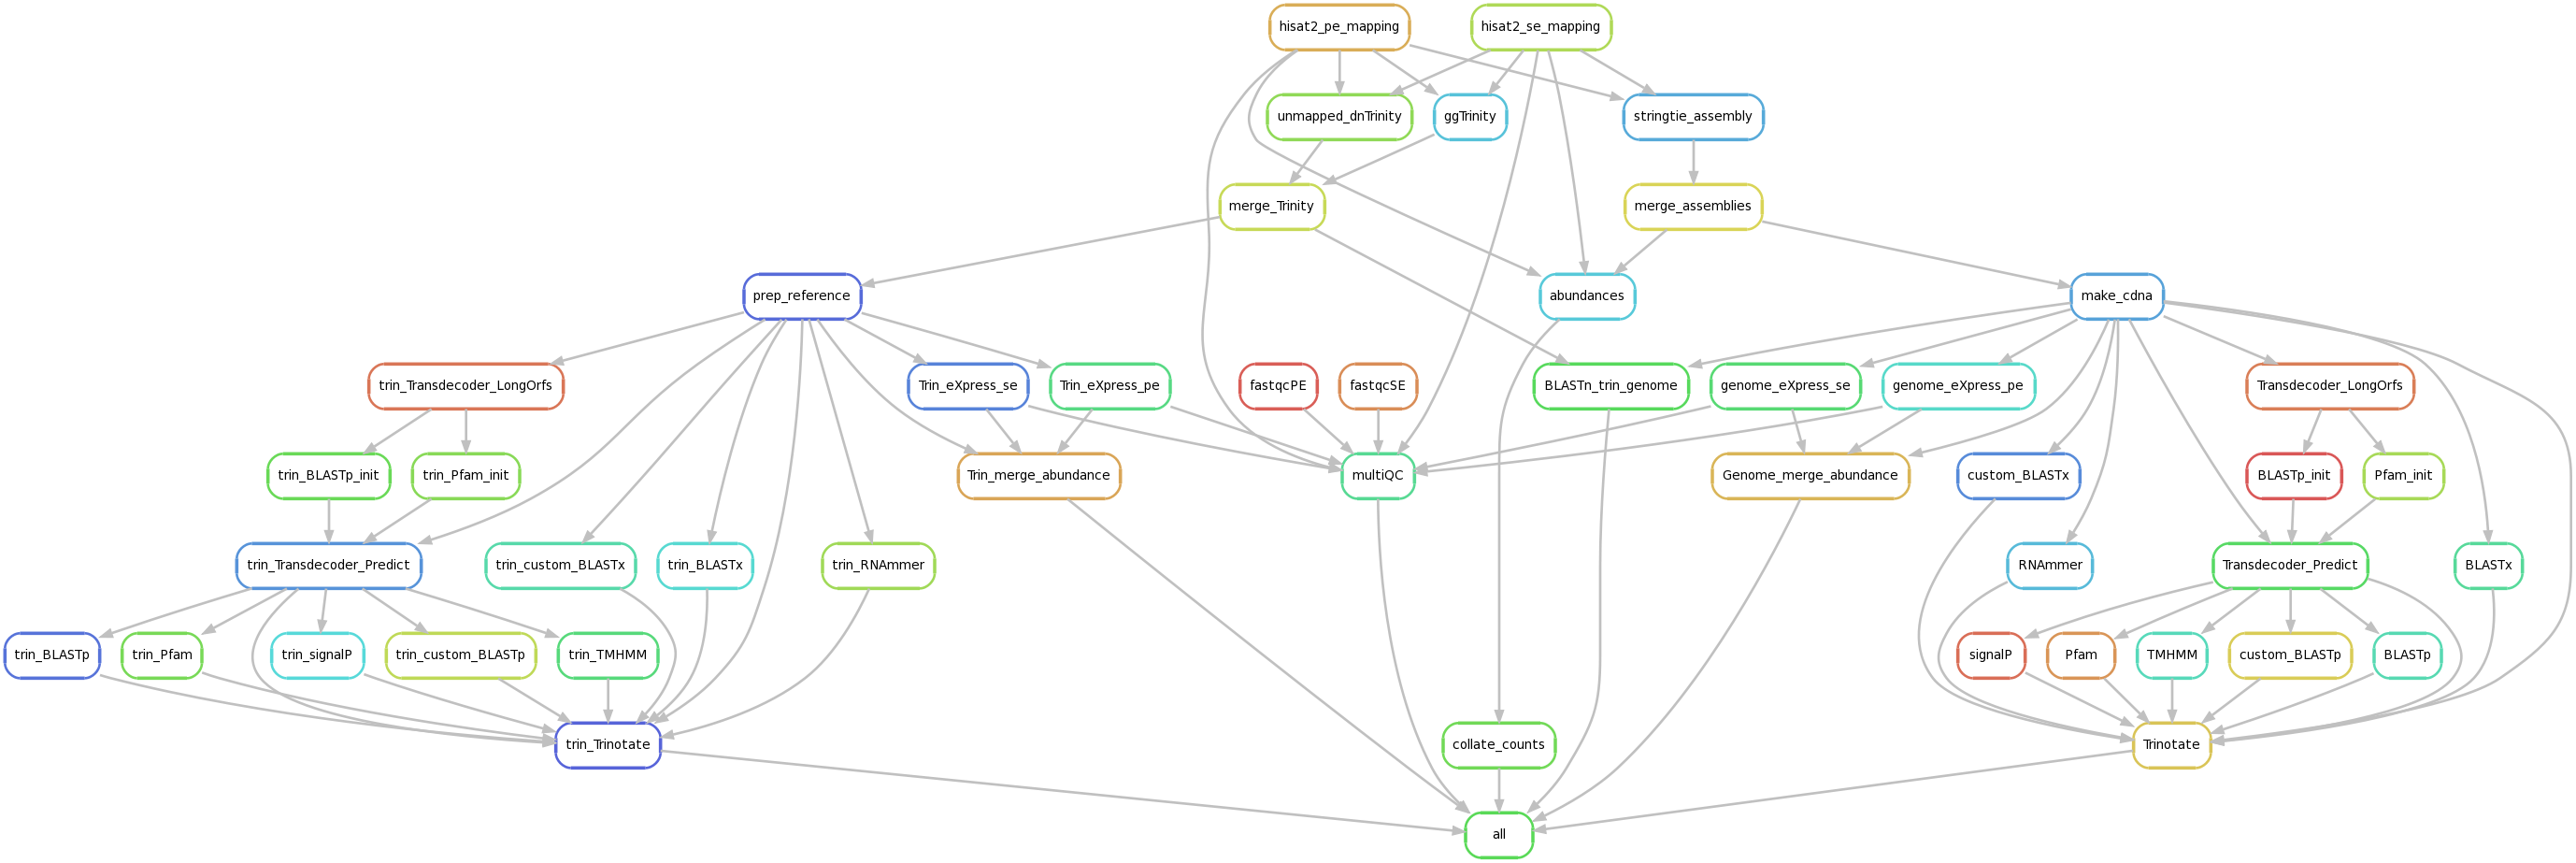

In [88]:
library("IRdisplay")
display_png(file="workflow.png")

#### Packages and functions:

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. The packages can be defined and loaded like so:

In [7]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr",
                 "wesanderson", "VennDiagram")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())


Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE

[[28]]
[1] TRUE

[[29]]
[1] TRUE

... and the custom functions are in a file that can be loaded like so:

In [25]:
source("Functions2.R")

#### Annotation files:

A Trinotate report and accompanying Gene Ontology assignments were produced for the genome-based transcriptome and the Trinity transcriptome. Load those here:

In [16]:
genomeTrinotate = read.csv("Snakemake_output_files/genome_Trinotate_report.xls_with_description_column.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)
trinityTrinotate = read.csv("Snakemake_output_files/trinity_Trinotate_report.xls_with_description_column.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

From these reports we also extracted the Gene Ontology (GO) assignments for each gene whenever possible:

In [17]:
genome_GO_info = read.table("Snakemake_output_files/genome_Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)
trinity_GO_info = read.table("Snakemake_output_files/trinity_Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)

For the genome data the gene IDs were FlyBase gene names (FBgn..), and we have a file that matches their gene anems and coordinates:

In [18]:
dv1.06_features = read.table("Annotations/Genome-based/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we have information on orthology to _D. melanogaster_:

In [19]:
melOrths = read.table(file = "Annotations/Genome-based/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

#### Expression files

There are three raw count matrices derived from each of the mapping/abundance steps described above. We'll load each of these:

In [20]:
hisat_geneCounts = read.csv("Snakemake_output_files/gene_counts.csv", sep = ",", header = T, row.names=1, com='', check.names=F)

bowtie2_genome_geneCounts = read.table("Snakemake_output_files/genome.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

bowtie2_trinity_geneCounts = read.table("Snakemake_output_files/trinity.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

For each the counts generated by eXpress there're normalized expression matrices in TPM units (we'll have to normalize the counts derived from HISAT2). Load those:

In [14]:
bowtie2_genome_TPM = read.table("Snakemake_output_files/genome.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

bowtie2_trinity_TPM = read.table("Snakemake_output_files/trinity.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

For normalizaing the hisat2 counts, we'll need the transcript lengths and the gene features files derived from the stringtie gtf. These were produced in the shell using previous scripts, and are loaded here:

In [15]:
gene.features = read.table("Snakemake_output_files/features.txt", header = T)
trans_lengths = read.csv("Snakemake_output_files/transcript_lengths.txt", header = T, sep = " ")

Using those two files, we can first get the gene lengths (we'll use the longest isoform's length for each gene) then obtain the TPM value for each gene:

In [35]:
# Merge transcript length file with gene features file:
tmpMrge = merge(trans_lengths, gene.features)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]

Now do the transformation:

In [29]:
hisat_TPM <- apply(hisat_geneCounts, 2, function(x) tpm(x, gene_lengths$length))
hisat_TPM = as.data.frame(hisat_TPM)

#### Miscellaneous files:

For the differential expression analysis we will need the sample-to-replicate mapping and any additional sample information. Those files were generated on an a spread sheet:

In [34]:
sampleData = read.table("Snakemake_output_files/samples.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]
sampleInfo = read.table("Snakemake_output_files/SampleInfo.txt", header=T, check.names=F, fill=T)
head(sampleInfo, n =2)

SampleName,Replicate,Sex,Tissue,Status,time
Female_C12_RT,Female_C12_RT_1,female,repTract,conspecific,12hpm
Female_C12_RT,Female_C12_RT_2,female,repTract,conspecific,12hpm


Because we're using both the genome- and trinity-based expression data, it would be convenient to compare the results between both analyses. For that we made a BLAST file between transcripts of both strategies (header line added manually), and will load that here:

In [33]:
trin_v_genome_blast = read.table("Snakemake_output_files/BLASTn.trinity_vs_genome.outfmt6", header = T, sep = "\t")
head(trin_v_genome_blast, n =2)

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
TRINITY_DN14079_c0_g1_i1,FBtr0229439,96.046,1315,52,0,99,1413,1325,11,0,2141
TRINITY_DN14079_c0_g2_i1,FBtr0229427,93.106,1291,89,0,1,1291,1301,11,0,1892


Finally, we have useful poopulation genetic data from a previous study that we can use later on:

In [40]:
paml.data = read.csv(file = "Annotations/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
KaKs.data = read.csv(file = "Annotations/Genome-based/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)

## Quality Assessment and Filtering:

We need to look at seevral QC metrics for our count data. First we'll look at the variation in library sizes across the thee analyses:

In [69]:
hisat2LibSizes <- as.data.frame(colSums(hisat_geneCounts))
bowtie2LibSizes <- as.data.frame(colSums(bowtie2_genome_geneCounts))
trinityLibSizes <- as.data.frame(colSums(bowtie2_trinity_geneCounts))
libSizes = cbind(hisat2LibSizes, bowtie2LibSizes, trinityLibSizes)
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "HISAT2", "Bowtie2 (genome)", "Bowtie2 (Trinity)")
libSizes = melt(libSizes, id.vars = "sample")
colnames(libSizes) = c("sample", "mapping_method", "mapped_reads")

Now make barplots of the mapped reads across samples and mapping methods:

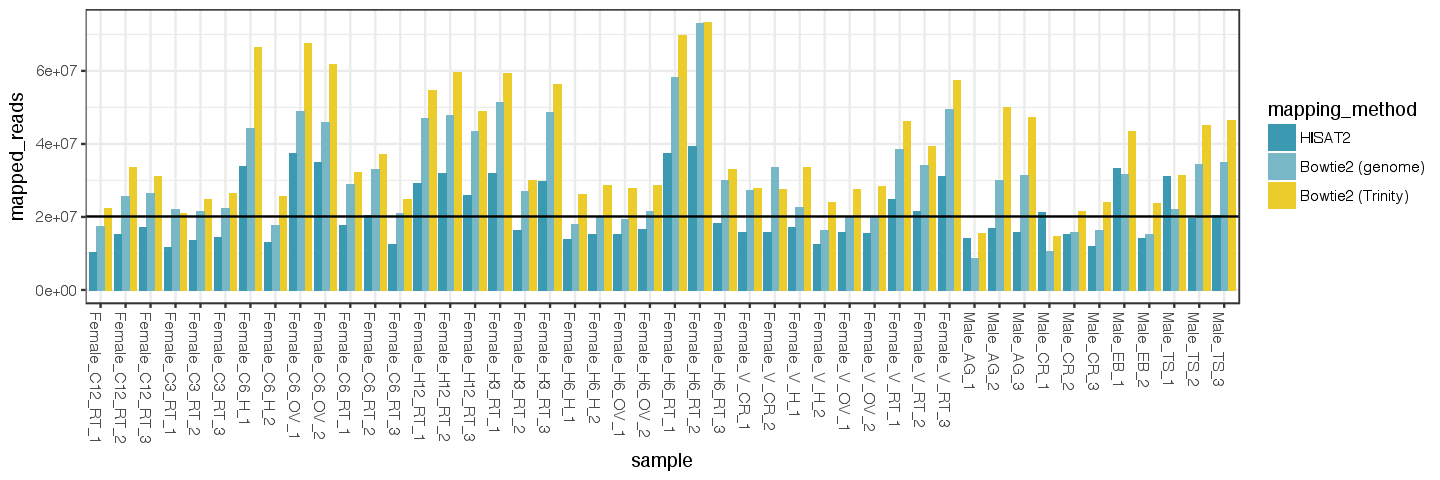

In [70]:
options(repr.plot.width = 12, repr.plot.height = 4)
ggplot(libSizes, aes(sample, mapped_reads, fill = mapping_method)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000) +
    scale_fill_manual(values = wes_palette("Zissou"))
    

A couple of things to note here. Not surprisingly, the Trinity mapping has the highest number of mapped reads across samples, while the HISAT2 genome mapping has the lowest (this is reflects in the percentage of mapping as well; see the MultiQC output from the Snakemake pipeline). Another thing to note is that, for the paired-end male data, there is no difference in the number of mapped reads between the HISAT2 and Trinity bowtie2 alignments, suggesting the genome divergence issues are mitigated by paired-end data. 

Now we can look at the appropriate cutoffs for filtering using Brian Haas' method. To do this we count the genes acrtoss a range of minimum TPM values. The eXpress output we used generates a file that can be used to generate this matrix (see Trinity online guidelines). We'll load those two files for the genom- and Trinity-based analyses:

In [89]:
genome.cbmtMatrix = read.table("Snakemake_output_files/genome.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)
trinity.cbmtMatrix = read.table("Snakemake_output_files/trinity.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)

First extract the "trully expressed genes" (in this case, between 10 and 100 TPM):

In [175]:
genome.cbmt.sub = genome.cbmtMatrix[genome.cbmtMatrix[,1] > -100 & genome.cbmtMatrix[,1] < -10,]
trinity.cbmt.sub = trinity.cbmtMatrix[trinity.cbmtMatrix[,1] > -100 & trinity.cbmtMatrix[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [176]:
genome.cbmt.sub_fit = lm(genome.cbmt.sub[,2] ~ genome.cbmt.sub[,1])
print(genome.cbmt.sub_fit)

trinity.cbmt.sub_fit = lm(trinity.cbmt.sub[,2] ~ trinity.cbmt.sub[,1])
print(trinity.cbmt.sub_fit)


Call:
lm(formula = genome.cbmt.sub[, 2] ~ genome.cbmt.sub[, 1])

Coefficients:
         (Intercept)  genome.cbmt.sub[, 1]  
            13173.37                 95.01  


Call:
lm(formula = trinity.cbmt.sub[, 2] ~ trinity.cbmt.sub[, 1])

Coefficients:
          (Intercept)  trinity.cbmt.sub[, 1]  
              35028.1                  328.2  



Combine both matrices before plotting:

Warning message:
"Ignoring unknown parameters: linestyle"Warning message:
"Removed 2639 rows containing missing values (geom_point)."Warning message:
"Removed 29 rows containing missing values (geom_smooth)."

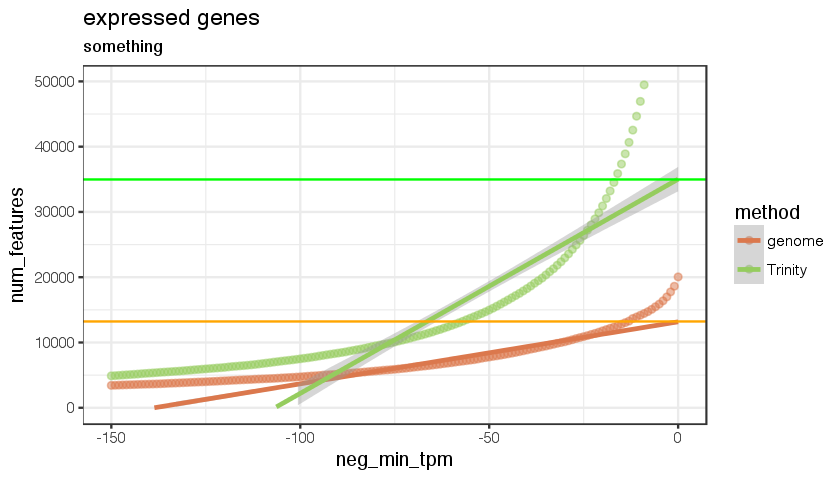

In [182]:
genome.cbmt.sub$method = "genome"
trinity.cbmt.sub$method = "Trinity"
cbmt.sub = rbind(genome.cbmt.sub, trinity.cbmt.sub)

genome.cbmtMatrix$method = "genome"
trinity.cbmtMatrix$method = "Trinity"
cbmtMatrix = rbind(genome.cbmtMatrix, trinity.cbmtMatrix)

options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(cbmtMatrix, aes(neg_min_tpm, num_features, colour = method)) + 
    geom_point(alpha = 0.5) +  
    scale_x_continuous(limits=c(-150,0)) + 
    scale_y_continuous(limits=c(0,50000)) + 
    geom_smooth(data=cbmt.sub, method = "lm",fullrange=TRUE) + 
    geom_hline(yintercept = 35028.1, colour = "green", linestyle = "dashed") + 
    geom_hline(yintercept = 13173.37, colour = "orange") + 
    ggtitle("expressed genes", subtitle = "something") +
    theme_bw()

In the Trinity analysis, out of 105593 "genes", roughly 35000 should remain after filtering lowly expressed genes. Simmilarly, 13000 out of ~20000 genes should remain in the genome analysis. Filtering should be performed on subsetted matrices for each analysis later because the threshold for the whole matrix tends to be too high, but we'll see what it is here. First, obtain the counts per million "CPM" matrix:

In [183]:
hs2.all.CPM <- cpm(hisat_geneCounts)
bt2.all.CPM <- cpm(bowtie2_genome_geneCounts)
trn.all.CPM <- cpm(bowtie2_trinity_geneCounts)

For now, let's set the minimum CPM to 10, and generate a logical matrix for CPM > 10:

In [184]:
hs2.thresh <- hs2.all.CPM > 10
bt2.thresh <- bt2.all.CPM > 10
trn.thresh <- trn.all.CPM > 10

We would like to keep genes that have at least 2 "TRUE"s in each row of thresh:

In [185]:
hs2.keep <- rowSums(hs2.thresh) >= 2
bt2.keep <- rowSums(bt2.thresh) >= 2
trn.keep <- rowSums(trn.thresh) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [186]:
hs2.counts.keep <- hisat_geneCounts[hs2.keep,]
dim(hs2.counts.keep)

bt2.counts.keep <- bowtie2_genome_geneCounts[bt2.keep,]
dim(bt2.counts.keep)

trn.counts.keep <- bowtie2_trinity_geneCounts[trn.keep,]
dim(trn.counts.keep)

[1] 11673    46

[1] 13333    46

[1] 40133    46

So a filter of 10 CPM brings the count matrix to the expected number of genes using Brian Haas' method. We would like to know what the CPM values correspond to in terms of raw counts. To do this, we'll plot CPM vs. counts for each sample. (look at 20 plts at a time)

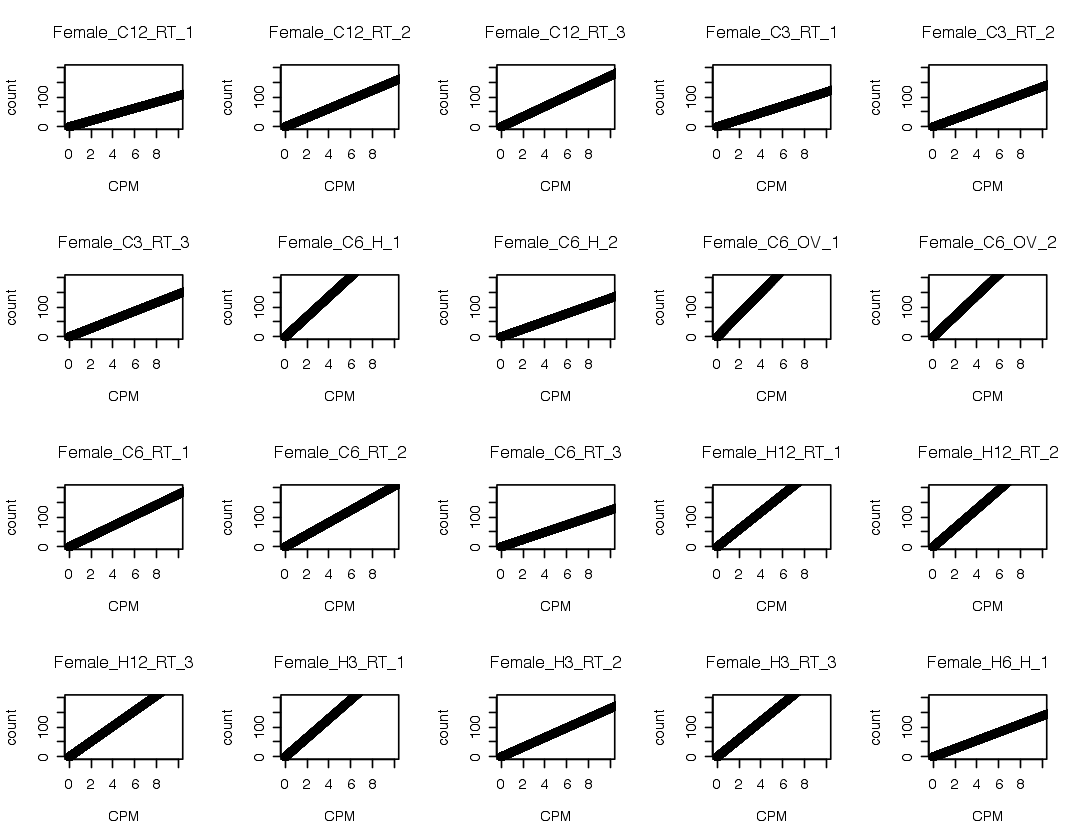

In [166]:
options(repr.plot.width = 9, repr.plot.height = 7)
par(mfrow=c(4,5))
for(i in seq(from=1, to=20, by=1)){
  plot(hs2.all.CPM[,i],hisat_geneCounts[,i], xlim=c(0,10), ylim=c(0,200), xlab = "CPM", ylab = "count")
  title(colnames(hs2.all.CPM)[i])
}

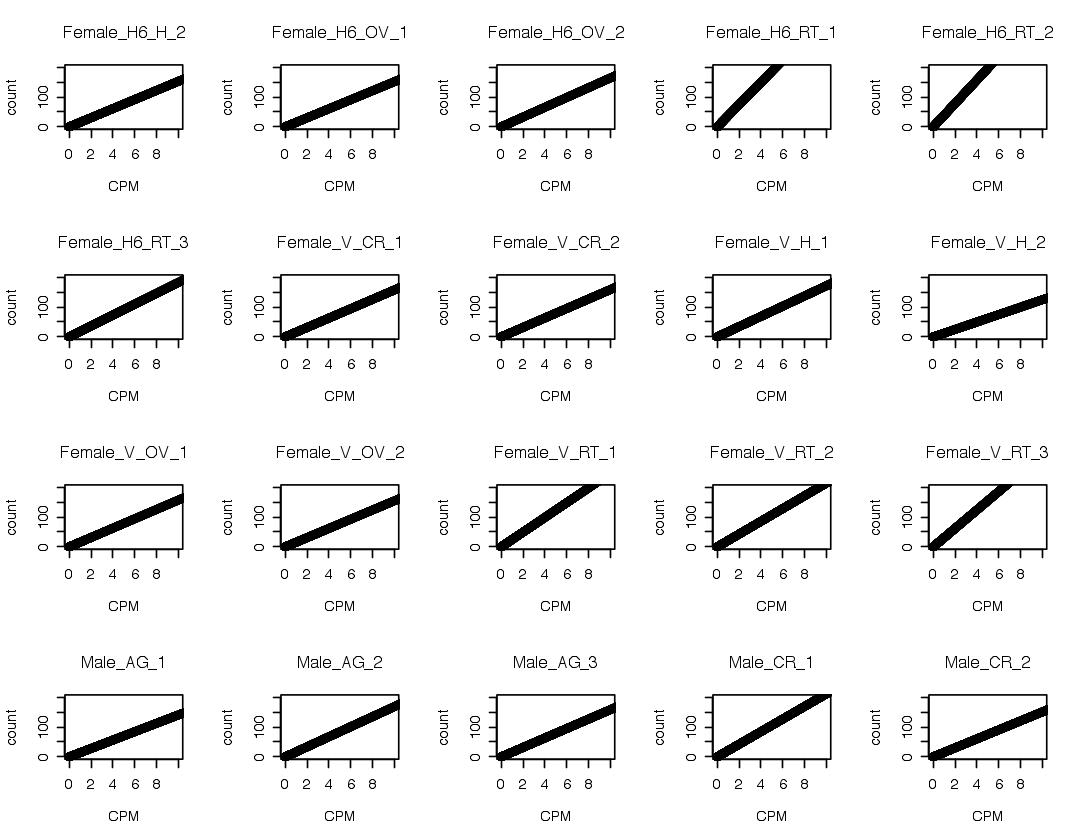

In [167]:
options(repr.plot.width = 9, repr.plot.height = 7)
par(mfrow=c(4,5))
for(i in seq(from=21, to=40, by=1)){
  plot(hs2.all.CPM[,i],hisat_geneCounts[,i], xlim=c(0,10), ylim=c(0,200), xlab = "CPM", ylab = "count")
  title(colnames(hs2.all.CPM)[i])
}

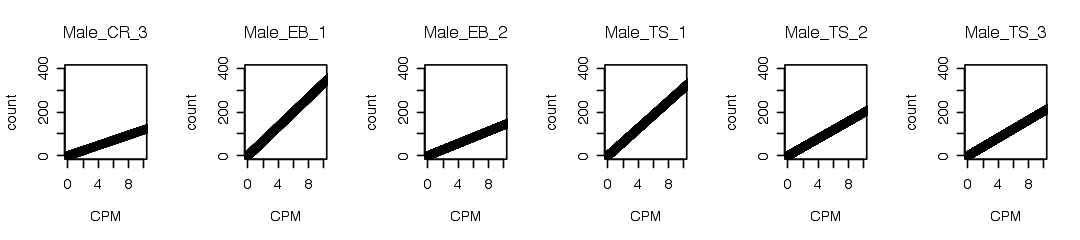

In [170]:
options(repr.plot.width = 9, repr.plot.height = 2)
par(mfrow=c(1,6))
for(i in seq(from=41, to=46, by=1)){
  plot(hs2.all.CPM[,i],hisat_geneCounts[,i], xlim=c(0,10), ylim=c(0,400), xlab = "CPM", ylab = "count")
  title(colnames(hs2.all.CPM)[i])
}

There's a arge range of correpondence between CPM values and raw counts. In general 10CPM seems to correspond to ~200 in raw counts.

## Differential Expression

### HISAT2:

In [197]:
hisat_geneCounts.female.virgin = subset(hisat_geneCounts, select=grepl("Female_V", colnames(hisat_geneCounts)))
hisat_geneCounts.male = subset(hisat_geneCounts, select=grepl("Male", colnames(hisat_geneCounts)))
hisat_geneCounts.tissues = cbind(hisat_geneCounts.female.virgin, hisat_geneCounts.male)

In [198]:
cpmMatrix.hisat_geneCounts.tissues <- cpm(hisat_geneCounts.tissues)
v.thresh <- cpmMatrix.hisat_geneCounts.tissues > 5
## look at number of columns with above requirements
table(rowSums(v.thresh))

v.keep <- rowSums(v.thresh) >= 3
countsMatrix.hisat_geneCounts.tissues.filt <- hisat_geneCounts.tissues[v.keep,]
## Check how many genes remain in the matrix.
dim(countsMatrix.hisat_geneCounts.tissues.filt)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
6712  493  812 2570  397  674  428  391  289  269  304  220  302  289  272  339 
  16   17   18   19   20 
 348  339  405  459 3737 

[1] 12032    20

In [ ]:
head(sampleInfo)

In [ ]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")
sampleInfo.v